In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

In [3]:
#for datetime calculations
from datetime import datetime
from dateutil.relativedelta import relativedelta


# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [7]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [10]:
# Find the most recent date in the data set.
recent_date_query = session.query(Measurement.date).\
              order_by(Measurement.date.desc()).first()

recent_date_query

('2017-08-23',)

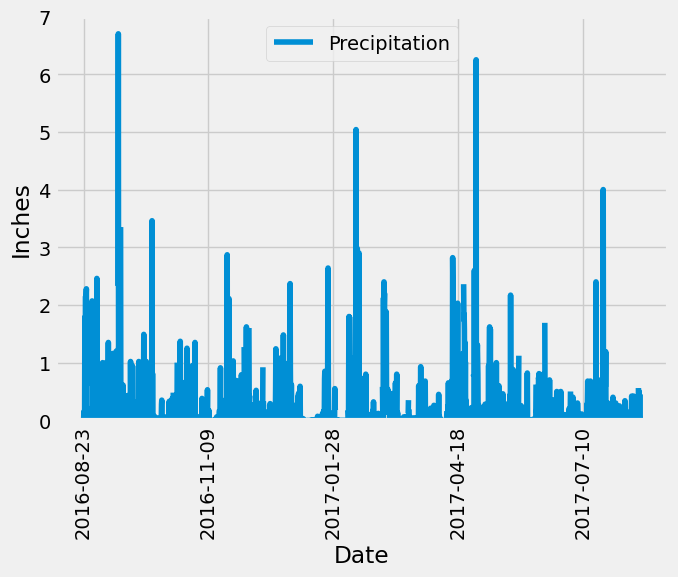

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

#taking the most recent date value out of the tuple, and turning it into a datetime value
recent_date = recent_date_query[0]
date_format = '%Y-%m-%d'
date = datetime.strptime(recent_date, date_format).date()

# Calculate the date one year from the last date in data set.
year_ago = date - relativedelta(months=12)

# Perform a query to retrieve the data and precipitation scores and sort queries by date
date_prcp = session.query(Measurement.date, Measurement.prcp).\
            order_by(Measurement.date).\
            filter(Measurement.date>=year_ago).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
date_prcp_df = pd.DataFrame(date_prcp, columns=['Date', 'Precipitation'])

#Sorting dataframe
date_prcp_df = date_prcp_df.sort_values("Date", ascending = True)

# Use Pandas Plotting with Matplotlib to plot the data
date_prcp_plot = date_prcp_df.plot(x='Date', y='Precipitation', label = 'Precipitation', ylabel='Inches', rot=90, ylim=(0,7), figsize=(7,6))
plt.tight_layout()
plt.show()


In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_summary_stats = date_prcp_df[['Precipitation']].describe()
prcp_summary_stats

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset
no_of_stations = session.query(Measurement.station).distinct().count()
no_of_stations

9

In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_activity = session.query(Measurement.station, func.count(Measurement.station)).\
                   group_by(Measurement.station).\
                   order_by(func.count(Measurement.station).desc()).all()

station_activity

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [17]:
# Answer the following question: which station id has the greatest number of observations?
most_active_station = station_activity[0][0]

# finding id number of most active station from the Stations table 
most_active_station_id = session.query(Station.id).\
                         filter(Station.station == most_active_station).first()[0]

print(f"Station {most_active_station} with id {most_active_station_id} has the greatest number of observations")


Station USC00519281 with id 7 has the greatest number of observations


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp_query = session.query(func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)).\
             filter(Measurement.station == most_active_station).all()
temp_query

[(54.0, 85.0, 71.66378066378067)]

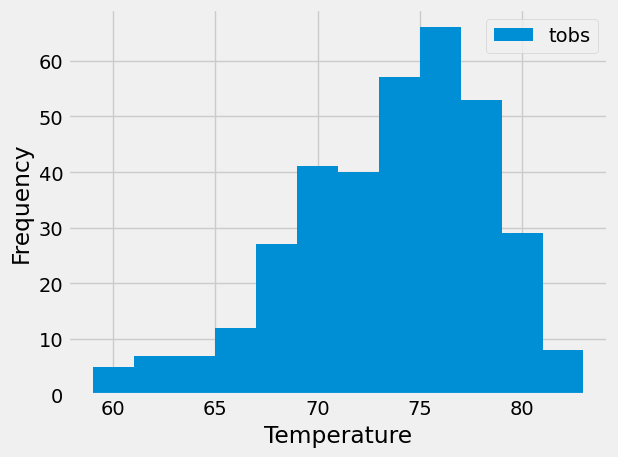

In [20]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

# using year_ago date calculated previously
active_temp = session.query(Measurement.tobs).filter(Measurement.station == most_active_station).\
              filter(Measurement.date>=year_ago).all()

# Adding data to a pandas dataframe
active_temp_df = pd.DataFrame(active_temp, columns=['Temperature'])

# plotting the histogram
plt.hist(active_temp_df, bins=12, label = 'tobs')
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend(loc="best")
plt.tight_layout()
plt.show()



# Close Session

In [21]:
# Close Session
session.close()